In [129]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from scipy import stats

# Download data

In [18]:
heart_disease = fetch_ucirepo(id=45)

In [50]:
X = heart_disease.data.features 
y = heart_disease.data.targets

In [51]:
df = pd.concat([X, y], axis=1)

In [52]:
df.rename(columns=({'num':'y'}),inplace=True)

# EDA & Cleansing

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    float64
 12  thal      303 non-null    float64
 13  y         303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


In [60]:
for col in df.columns:
    mode_val = df[col].mode()
    if not mode_val.empty:
        df[col] = df[col].fillna(mode_val[0])

In [67]:
pd.set_option("display.float", "{:.2f}".format)
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,y
count,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00
mean,54.44,0.68,3.16,131.69,246.69,0.15,0.99,149.61,0.33,1.04,1.60,0.66,4.72,0.94
std,9.04,0.47,0.96,17.60,51.78,0.36,0.99,22.88,0.47,1.16,0.62,0.93,1.94,1.23
min,29.00,0.00,1.00,94.00,126.00,0.00,0.00,71.00,0.00,0.00,1.00,0.00,3.00,0.00
25%,48.00,0.00,3.00,120.00,211.00,0.00,0.00,133.50,0.00,0.00,1.00,0.00,3.00,0.00
50%,56.00,1.00,3.00,130.00,241.00,0.00,1.00,153.00,0.00,0.80,2.00,0.00,3.00,0.00
75%,61.00,1.00,4.00,140.00,275.00,0.00,2.00,166.00,1.00,1.60,2.00,1.00,7.00,2.00
max,77.00,1.00,4.00,200.00,564.00,1.00,2.00,202.00,1.00,6.20,3.00,3.00,7.00,4.00


In [70]:
df.y.value_counts()


y
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

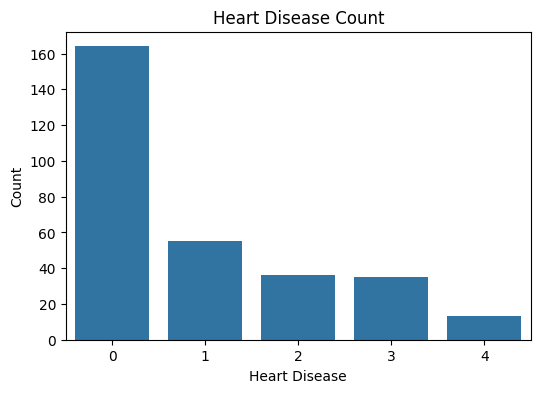

In [74]:
plt.figure(figsize=(6,4))
sns.countplot(x='y', data=df)
plt.title("Heart Disease Count")
plt.xlabel("Heart Disease")
plt.ylabel("Count")
plt.show()

In [77]:
categorical_val = []
continous_val = []
for column in df.columns:
    if len(df[column].unique()) <= 10:
        categorical_val.append(column)
    else:
        continous_val.append(column)

In [78]:
categorical_val

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'y']

In [79]:
continous_val

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

#### description
- cp {Chest Pain} : People with cp equl to 1, 2, 3 are more likely to have heart disease than people with cp equal to 0.
- restecg {resting electrocardiographic results} : People with value 1 (signals non-normal heart beat, can range from mild symptoms to severe problems) are more likely to have heart disease.
- exang {exercise induced angina} : People with value 0 (No ==> exercice induced angina) have heart disease more than people with value 1 (Yes ==> exercice induced angina)
- slope {the slope of the peak exercise ST segment} : People with slope value equal to 2 (Downslopins: signs of unhealthy heart) are more likely to have heart disease than people with slope value equal to 0 (Upsloping: better heart rate with excercise) or 1 (Flatsloping: minimal change (typical healthy heart)).
- ca {number of major vessels (0-3) colored by flourosopy} : the more blood movement the better so people with ca equal to 0 are more likely to have heart disease.
- thal {thalium stress result} : People with thal value equal to 2 (fixed defect: used to be defect but ok now) are more likely to have heart disease.

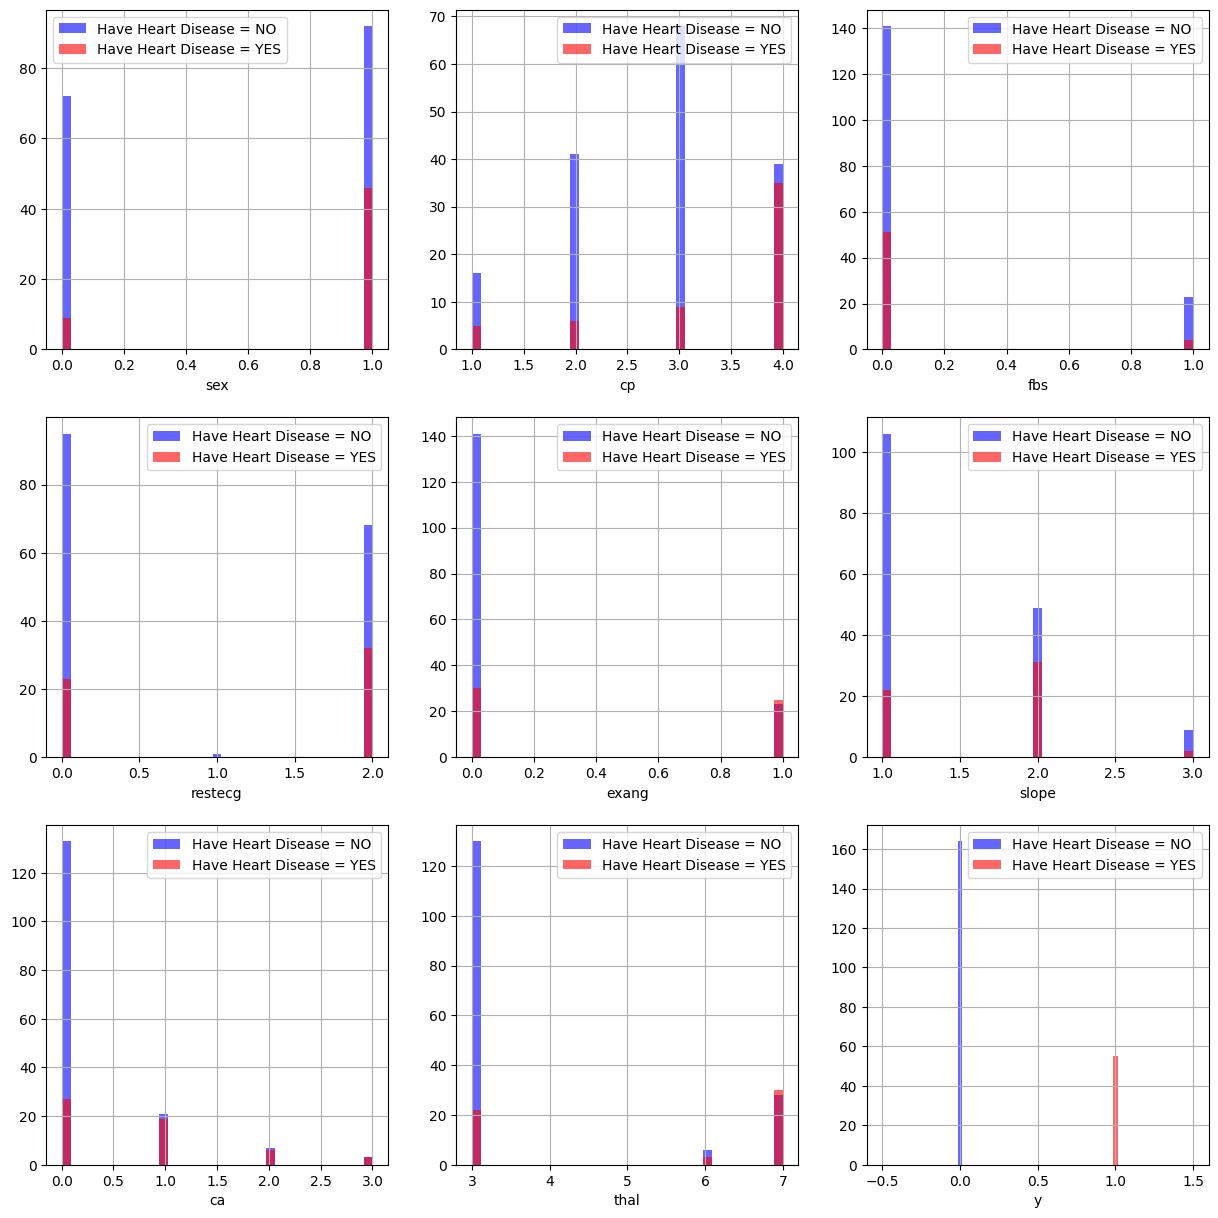

In [82]:
plt.figure(figsize=(15, 15))

for i, column in enumerate(categorical_val, 1):
    plt.subplot(3, 3, i)
    df[df["y"] == 0][column].hist(bins=35, color='blue', label='Have Heart Disease = NO', alpha=0.6)
    df[df["y"] == 1][column].hist(bins=35, color='red', label='Have Heart Disease = YES', alpha=0.6)
    plt.legend()
    plt.xlabel(column)

#### Desciption
- trestbps : resting blood pressure (in mm Hg on admission to the hospital) anything above 130-140 is typically cause for concern
- chol {serum cholestoral in mg/dl} : above 200 is cause for concern.
- thalach {maximum heart rate achieved} : People how acheived a maximum more than 140 are more likely to have heart disease.
- oldpeak ST depression induced by exercise relative to rest looks at stress of heart during excercise unhealthy heart will stress more

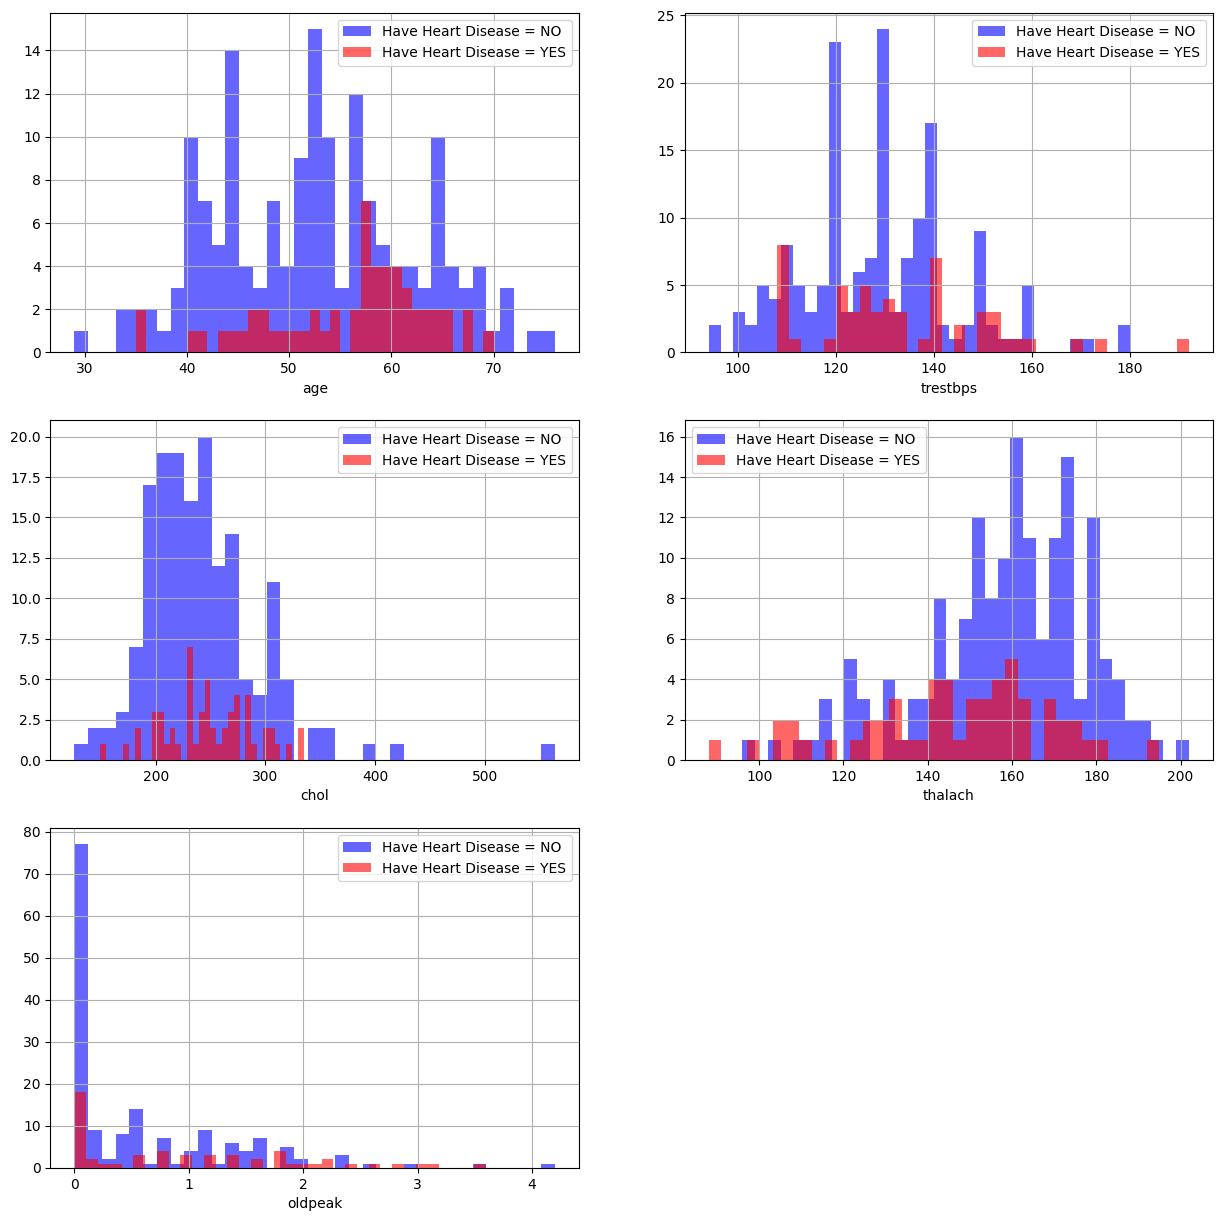

In [83]:
plt.figure(figsize=(15, 15))

for i, column in enumerate(continous_val, 1):
    plt.subplot(3, 2, i)
    df[df["y"] == 0][column].hist(bins=35, color='blue', label='Have Heart Disease = NO', alpha=0.6)
    df[df["y"] == 1][column].hist(bins=35, color='red', label='Have Heart Disease = YES', alpha=0.6)
    plt.legend()
    plt.xlabel(column)

(14.5, -0.5)

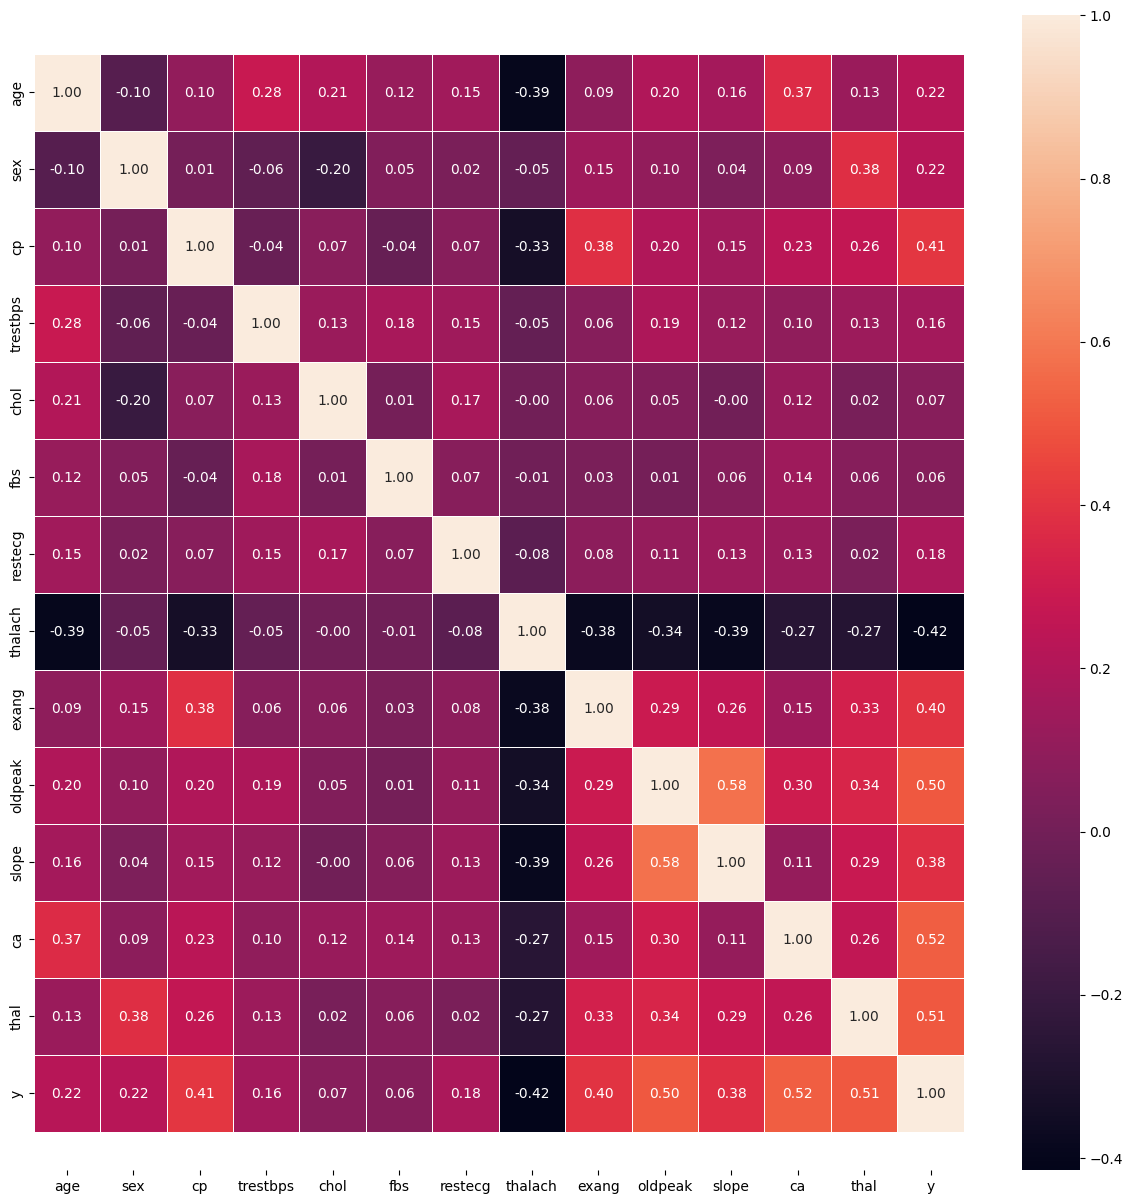

In [85]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

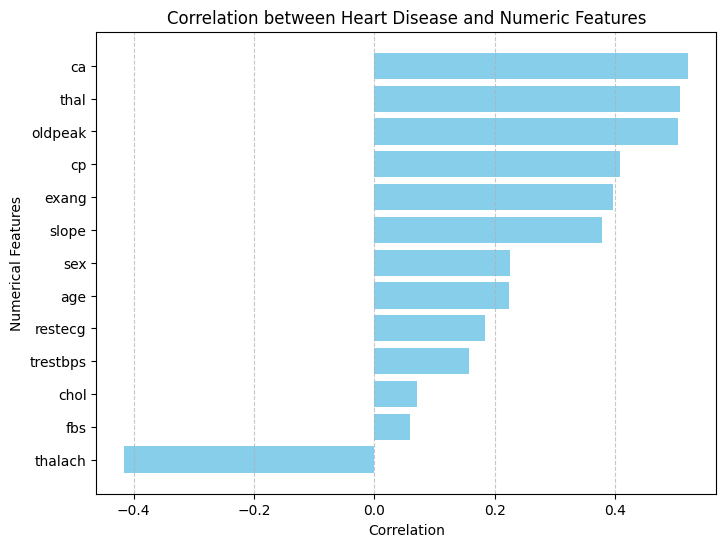

In [87]:
corr = df.drop('y', axis=1).corrwith(df['y']).sort_values()

plt.figure(figsize=(8, 6))
plt.barh(corr.index, corr.values, color='skyblue')
plt.title("Correlation between Heart Disease and Numeric Features")
plt.xlabel("Correlation")
plt.ylabel("Numerical Features")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Data Prepareration

In [ ]:
categorical_val.remove('y')
dataset = pd.get_dummies(df, columns = categorical_val)

In [92]:
s_sc = StandardScaler()
col_to_scale = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
dataset[col_to_scale] = s_sc.fit_transform(dataset[col_to_scale])

In [93]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [95]:
X = dataset.drop('y', axis=1)
y = dataset.y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model

### 1. Logistic Regression

In [96]:
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)

print_score(lr_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lr_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 66.98%
_______________________________________________
CLASSIFICATION REPORT:
               0     1     2     3    4  accuracy  macro avg  weighted avg
precision   0.81  0.32  0.41  0.50 0.33      0.67       0.48          0.62
recall      0.97  0.24  0.29  0.52 0.11      0.67       0.43          0.67
f1-score    0.88  0.27  0.34  0.51 0.17      0.67       0.43          0.64
support   116.00 38.00 24.00 25.00 9.00      0.67     212.00        212.00
_______________________________________________
Confusion Matrix: 
 [[112   4   0   0   0]
 [ 20   9   4   5   0]
 [  2   8   7   6   1]
 [  2   5   4  13   1]
 [  2   2   2   2   1]]

Test Result:
Accuracy Score: 54.95%
_______________________________________________
CLASSIFICATION REPORT:
              0     1     2     3    4  accuracy  macro avg  weighted avg
precision  0.74  0.23  0.12  0.31 0.00      0.55       0.28          0.48
recall     0.88  0.18  0.08  0.40 0.00      0.55       0.31          0.55
f1-

d:\Fon\heart_disease\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [97]:
test_score = accuracy_score(y_test, lr_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, lr_clf.predict(X_train)) * 100

results_df = pd.DataFrame(data=[["Logistic Regression", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,66.98,54.95


### 2. KNN

In [98]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

print_score(knn_clf, X_train, y_train, X_test, y_test, train=True)
print_score(knn_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 68.87%
_______________________________________________
CLASSIFICATION REPORT:
               0     1     2     3    4  accuracy  macro avg  weighted avg
precision   0.80  0.43  0.53  0.70 0.00      0.69       0.49          0.66
recall      0.94  0.53  0.42  0.28 0.00      0.69       0.43          0.69
f1-score    0.86  0.48  0.47  0.40 0.00      0.69       0.44          0.66
support   116.00 38.00 24.00 25.00 9.00      0.69     212.00        212.00
_______________________________________________
Confusion Matrix: 
 [[109   7   0   0   0]
 [ 16  20   1   1   0]
 [  5   8  10   1   0]
 [  4   7   7   7   0]
 [  3   4   1   1   0]]

Test Result:
Accuracy Score: 60.44%
_______________________________________________
CLASSIFICATION REPORT:
              0     1     2     3    4  accuracy  macro avg  weighted avg
precision  0.79  0.28  0.33  0.25 1.00      0.60       0.53          0.58
recall     0.92  0.29  0.33  0.10 0.25      0.60       0.38          0.60
f1-

d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [102]:
test_score = accuracy_score(y_test, knn_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, knn_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["K-nearest neighbors", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])

results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,66.98,54.95
1,K-nearest neighbors,68.87,60.44


### 3. SVM

In [103]:
svm_clf = SVC(kernel='rbf', gamma=0.1, C=1.0)
svm_clf.fit(X_train, y_train)

print_score(svm_clf, X_train, y_train, X_test, y_test, train=True)
print_score(svm_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 79.25%
_______________________________________________
CLASSIFICATION REPORT:
               0     1     2     3    4  accuracy  macro avg  weighted avg
precision   0.81  0.67  0.75  0.90 0.00      0.79       0.63          0.75
recall      0.99  0.53  0.62  0.72 0.00      0.79       0.57          0.79
f1-score    0.89  0.59  0.68  0.80 0.00      0.79       0.59          0.76
support   116.00 38.00 24.00 25.00 9.00      0.79     212.00        212.00
_______________________________________________
Confusion Matrix: 
 [[115   1   0   0   0]
 [ 18  20   0   0   0]
 [  4   4  15   1   0]
 [  3   3   1  18   0]
 [  2   2   4   1   0]]

Test Result:
Accuracy Score: 60.44%
_______________________________________________
CLASSIFICATION REPORT:
              0     1     2     3    4  accuracy  macro avg  weighted avg
precision  0.74  0.33  0.25  0.20 0.00      0.60       0.30          0.51
recall     1.00  0.24  0.08  0.20 0.00      0.60       0.30          0.60
f1-

d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Fon\heart_disease\env\Lib

In [ ]:
test_score = accuracy_score(y_test, svm_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, svm_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["Support Vector Machine", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])

results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,66.98,54.95
1,K-nearest neighbors,68.87,60.44
2,Support Vector Machine,79.25,60.44


### 4. Decision Tree

In [105]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0     1     2     3    4  accuracy  macro avg  weighted avg
precision   1.00  1.00  1.00  1.00 1.00      1.00       1.00          1.00
recall      1.00  1.00  1.00  1.00 1.00      1.00       1.00          1.00
f1-score    1.00  1.00  1.00  1.00 1.00      1.00       1.00          1.00
support   116.00 38.00 24.00 25.00 9.00      1.00     212.00        212.00
_______________________________________________
Confusion Matrix: 
 [[116   0   0   0   0]
 [  0  38   0   0   0]
 [  0   0  24   0   0]
 [  0   0   0  25   0]
 [  0   0   0   0   9]]

Test Result:
Accuracy Score: 46.15%
_______________________________________________
CLASSIFICATION REPORT:
              0     1     2     3    4  accuracy  macro avg  weighted avg
precision  0.74  0.13  0.29  0.17 0.00      0.46       0.26          0.47
recall     0.71  0.18  0.33  0.10 0.00      0.46       0.26          0.46
f1

In [106]:
test_score = accuracy_score(y_test, tree_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, tree_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["Decision Tree Classifier", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])

results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,66.98,54.95
1,K-nearest neighbors,68.87,60.44
2,Support Vector Machine,79.25,60.44
3,Decision Tree Classifier,100.00,46.15


### 5. RF

In [107]:
rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_clf.fit(X_train, y_train)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0     1     2     3    4  accuracy  macro avg  weighted avg
precision   1.00  1.00  1.00  1.00 1.00      1.00       1.00          1.00
recall      1.00  1.00  1.00  1.00 1.00      1.00       1.00          1.00
f1-score    1.00  1.00  1.00  1.00 1.00      1.00       1.00          1.00
support   116.00 38.00 24.00 25.00 9.00      1.00     212.00        212.00
_______________________________________________
Confusion Matrix: 
 [[116   0   0   0   0]
 [  0  38   0   0   0]
 [  0   0  24   0   0]
 [  0   0   0  25   0]
 [  0   0   0   0   9]]

Test Result:
Accuracy Score: 53.85%
_______________________________________________
CLASSIFICATION REPORT:
              0     1     2     3    4  accuracy  macro avg  weighted avg
precision  0.76  0.18  0.12  0.00 0.00      0.54       0.21          0.45
recall     0.94  0.18  0.08  0.00 0.00      0.54       0.24          0.54
f1

d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [108]:
test_score = accuracy_score(y_test, rf_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, rf_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["Random Forest Classifier", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])

results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,66.98,54.95
1,K-nearest neighbors,68.87,60.44
2,Support Vector Machine,79.25,60.44
3,Decision Tree Classifier,100.00,46.15
4,Random Forest Classifier,100.00,53.85


### 6. XGB

In [109]:
xgb_clf = XGBClassifier(use_label_encoder=False)
xgb_clf.fit(X_train, y_train)

print_score(xgb_clf, X_train, y_train, X_test, y_test, train=True)
print_score(xgb_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0     1     2     3    4  accuracy  macro avg  weighted avg
precision   1.00  1.00  1.00  1.00 1.00      1.00       1.00          1.00
recall      1.00  1.00  1.00  1.00 1.00      1.00       1.00          1.00
f1-score    1.00  1.00  1.00  1.00 1.00      1.00       1.00          1.00
support   116.00 38.00 24.00 25.00 9.00      1.00     212.00        212.00
_______________________________________________
Confusion Matrix: 
 [[116   0   0   0   0]
 [  0  38   0   0   0]
 [  0   0  24   0   0]
 [  0   0   0  25   0]
 [  0   0   0   0   9]]

Test Result:
Accuracy Score: 49.45%
_______________________________________________
CLASSIFICATION REPORT:
              0     1     2     3    4  accuracy  macro avg  weighted avg
precision  0.76  0.12  0.00  0.10 0.50      0.49       0.30          0.46
recall     0.85  0.12  0.00  0.10 0.25      0.49       0.26          0.49
f1

d:\Fon\heart_disease\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:31:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [110]:
test_score = accuracy_score(y_test, xgb_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, xgb_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(data=[["XGBoost Classifier", train_score, test_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %'])

results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Logistic Regression,66.98,54.95
1,K-nearest neighbors,68.87,60.44
2,Support Vector Machine,79.25,60.44
3,Decision Tree Classifier,100.00,46.15
4,Random Forest Classifier,100.00,53.85
5,XGBoost Classifier,100.00,49.45


# Tuning hyperparameter

### 1. Logistic Regression

In [111]:
params = {"C": np.logspace(-4, 4, 20),
          "solver": ["liblinear"]}

lr_clf = LogisticRegression()

lr_cv = GridSearchCV(lr_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=5)
lr_cv.fit(X_train, y_train)
best_params = lr_cv.best_params_
print(f"Best parameters: {best_params}")
lr_clf = LogisticRegression(**best_params)

lr_clf.fit(X_train, y_train)

print_score(lr_clf, X_train, y_train, X_test, y_test, train=True)
print_score(lr_clf, X_train, y_train, X_test, y_test, train=False)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'C': np.float64(0.615848211066026), 'solver': 'liblinear'}
Train Result:
Accuracy Score: 67.45%
_______________________________________________
CLASSIFICATION REPORT:
               0     1     2     3    4  accuracy  macro avg  weighted avg
precision   0.81  0.33  0.42  0.50 1.00      0.67       0.61          0.65
recall      0.97  0.24  0.33  0.52 0.11      0.67       0.43          0.67
f1-score    0.88  0.28  0.37  0.51 0.20      0.67       0.45          0.64
support   116.00 38.00 24.00 25.00 9.00      0.67     212.00        212.00
_______________________________________________
Confusion Matrix: 
 [[112   4   0   0   0]
 [ 20   9   4   5   0]
 [  3   7   8   6   0]
 [  2   5   5  13   0]
 [  2   2   2   2   1]]

Test Result:
Accuracy Score: 56.04%
_______________________________________________
CLASSIFICATION REPORT:
              0     1     2     3    4  accuracy  macro avg  weighted avg
precision  0

d:\Fon\heart_disease\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
d:\Fon\heart_disease\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

In [112]:
test_score = accuracy_score(y_test, lr_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, lr_clf.predict(X_train)) * 100

tuning_results_df = pd.DataFrame(
    data=[["Tuned Logistic Regression", train_score, test_score]], 
    columns=['Model', 'Training Accuracy %', 'Testing Accuracy %']
)
tuning_results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Tuned Logistic Regression,67.45,56.04


### 2. KNN

In [113]:
train_score = []
test_score = []
neighbors = range(1, 30)

for k in neighbors:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    train_score.append(accuracy_score(y_train, model.predict(X_train)))
#     test_score.append(accuracy_score(y_test, model.predict(X_test)))

Maximum KNN score on the test data: 100.00%


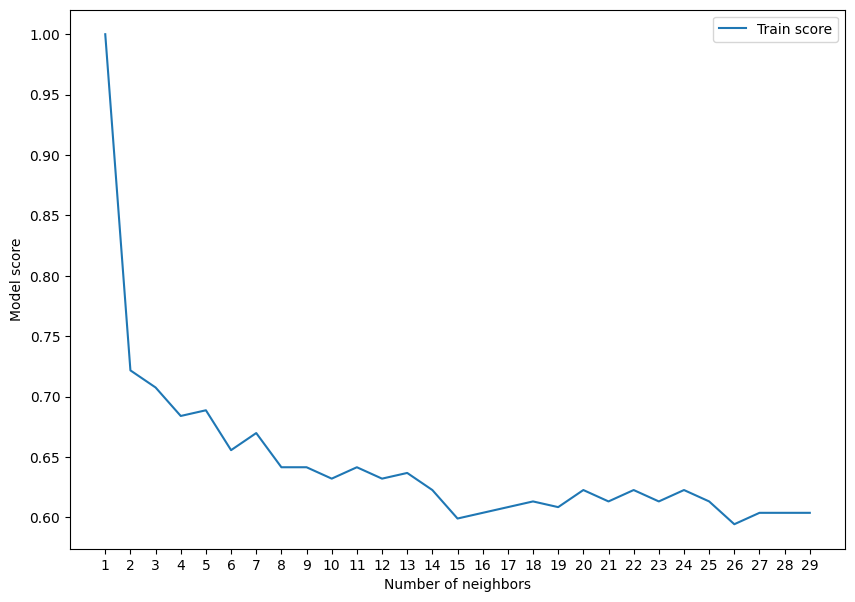

In [115]:
plt.figure(figsize=(10, 7))

plt.plot(neighbors, train_score, label="Train score")
plt.xticks(np.arange(1, 30, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum KNN score on the test data: {max(train_score)*100:.2f}%")

In [116]:
knn_clf = KNeighborsClassifier(n_neighbors=27)
knn_clf.fit(X_train, y_train)

print_score(knn_clf, X_train, y_train, X_test, y_test, train=True)
print_score(knn_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 60.38%
_______________________________________________
CLASSIFICATION REPORT:
               0     1     2     3    4  accuracy  macro avg  weighted avg
precision   0.69  0.21  0.33  0.56 0.00      0.60       0.36          0.52
recall      0.97  0.16  0.17  0.20 0.00      0.60       0.30          0.60
f1-score    0.81  0.18  0.22  0.29 0.00      0.60       0.30          0.54
support   116.00 38.00 24.00 25.00 9.00      0.60     212.00        212.00
_______________________________________________
Confusion Matrix: 
 [[113   2   0   1   0]
 [ 28   6   3   1   0]
 [  9   9   4   2   0]
 [ 10   8   2   5   0]
 [  3   3   3   0   0]]

Test Result:
Accuracy Score: 57.14%
_______________________________________________
CLASSIFICATION REPORT:
              0     1     2     3    4  accuracy  macro avg  weighted avg
precision  0.69  0.33  0.00  0.00 0.00      0.57       0.20          0.42
recall     0.96  0.35  0.00  0.00 0.00      0.57       0.26          0.57
f1-

d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Fon\heart_disease\env\Lib

In [117]:
test_score = accuracy_score(y_test, knn_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, knn_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(
    data=[["Tuned K-nearest neighbors", train_score, test_score]], 
    columns=['Model', 'Training Accuracy %', 'Testing Accuracy %']
)

tuning_results_df = pd.concat([tuning_results_df,results_df_2],ignore_index=True)
tuning_results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Tuned Logistic Regression,67.45,56.04
1,Tuned K-nearest neighbors,60.38,57.14


### 3. SVM

In [118]:
svm_clf = SVC(kernel='rbf', gamma=0.1, C=1.0)

params = {"C":(0.1, 0.5, 1, 2, 5, 10, 20), 
          "gamma":(0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1), 
          "kernel":('linear', 'poly', 'rbf')}

svm_cv = GridSearchCV(svm_clf, params, n_jobs=-1, cv=5, verbose=1, scoring="accuracy")
svm_cv.fit(X_train, y_train)
best_params = svm_cv.best_params_
print(f"Best params: {best_params}")

svm_clf = SVC(**best_params)
svm_clf.fit(X_train, y_train)

print_score(svm_clf, X_train, y_train, X_test, y_test, train=True)
print_score(svm_clf, X_train, y_train, X_test, y_test, train=False)

Fitting 5 folds for each of 147 candidates, totalling 735 fits
Best params: {'C': 20, 'gamma': 0.001, 'kernel': 'rbf'}
Train Result:
Accuracy Score: 64.15%
_______________________________________________
CLASSIFICATION REPORT:
               0     1     2     3    4  accuracy  macro avg  weighted avg
precision   0.73  0.30  0.36  0.64 0.00      0.64       0.40          0.57
recall      0.98  0.21  0.21  0.36 0.00      0.64       0.35          0.64
f1-score    0.84  0.25  0.26  0.46 0.00      0.64       0.36          0.59
support   116.00 38.00 24.00 25.00 9.00      0.64     212.00        212.00
_______________________________________________
Confusion Matrix: 
 [[114   2   0   0   0]
 [ 27   8   3   0   0]
 [  8   7   5   4   0]
 [  6   7   3   9   0]
 [  2   3   3   1   0]]

Test Result:
Accuracy Score: 58.24%
_______________________________________________
CLASSIFICATION REPORT:
              0     1     2     3    4  accuracy  macro avg  weighted avg
precision  0.72  0.14  0.25  0.2

d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Fon\heart_disease\env\Lib

In [120]:
test_score = accuracy_score(y_test, svm_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, svm_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(
    data=[["Tuned Support Vector Machine", train_score, test_score]], 
    columns=['Model', 'Training Accuracy %', 'Testing Accuracy %']
)

tuning_results_df = pd.concat([tuning_results_df,results_df_2],ignore_index=True)
tuning_results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Tuned Logistic Regression,67.45,56.04
1,Tuned K-nearest neighbors,60.38,57.14
2,Tuned Support Vector Machine,64.15,58.24


### 4. Decision Tree

In [121]:
params = {"criterion":("gini", "entropy"), 
          "splitter":("best", "random"), 
          "max_depth":(list(range(1, 20))), 
          "min_samples_split":[2, 3, 4], 
          "min_samples_leaf":list(range(1, 20))
          }

tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=5)
tree_cv.fit(X_train, y_train)
best_params = tree_cv.best_params_
print(f'Best_params: {best_params}')

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(X_train, y_train)

print_score(tree_clf, X_train, y_train, X_test, y_test, train=True)
print_score(tree_clf, X_train, y_train, X_test, y_test, train=False)

Fitting 5 folds for each of 4332 candidates, totalling 21660 fits
Best_params: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 12, 'min_samples_split': 2, 'splitter': 'best'}
Train Result:
Accuracy Score: 64.15%
_______________________________________________
CLASSIFICATION REPORT:
               0     1     2     3    4  accuracy  macro avg  weighted avg
precision   0.84  0.33  0.41  0.36 0.00      0.64       0.39          0.61
recall      0.89  0.34  0.50  0.32 0.00      0.64       0.41          0.64
f1-score    0.87  0.34  0.45  0.34 0.00      0.64       0.40          0.63
support   116.00 38.00 24.00 25.00 9.00      0.64     212.00        212.00
_______________________________________________
Confusion Matrix: 
 [[103   8   5   0   0]
 [ 14  13   9   2   0]
 [  3   2  12   7   0]
 [  2  12   3   8   0]
 [  0   4   0   5   0]]

Test Result:
Accuracy Score: 52.75%
_______________________________________________
CLASSIFICATION REPORT:
              0     1     2     3    

d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Fon\heart_disease\env\Lib

In [122]:
test_score = accuracy_score(y_test, tree_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, tree_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(
    data=[["Tuned Decision Tree Classifier", train_score, test_score]], 
    columns=['Model', 'Training Accuracy %', 'Testing Accuracy %']
)

tuning_results_df = pd.concat([tuning_results_df,results_df_2],ignore_index=True)
tuning_results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Tuned Logistic Regression,67.45,56.04
1,Tuned K-nearest neighbors,60.38,57.14
2,Tuned Support Vector Machine,64.15,58.24
3,Tuned Decision Tree Classifier,64.15,52.75


### 5. RF

In [123]:
n_estimators = [500, 900, 1100, 1500]
max_features = ['auto', 'sqrt']
max_depth = [2, 3, 5, 10, 15, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

params_grid = {
    'n_estimators': n_estimators, 
    'max_features': max_features,
    'max_depth': max_depth, 
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
              }

rf_clf = RandomForestClassifier(random_state=42)
rf_cv = GridSearchCV(rf_clf, params_grid, scoring="accuracy", cv=5, verbose=1, n_jobs=-1)
rf_cv.fit(X_train, y_train)
best_params = rf_cv.best_params_
print(f"Best parameters: {best_params}")

rf_clf = RandomForestClassifier(**best_params)
rf_clf.fit(X_train, y_train)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


d:\Fon\heart_disease\env\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
1080 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
529 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Fon\heart_disease\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Fon\heart_disease\env\Lib\site-packages\sklearn\base.py", line 1356, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "d:\Fon\heart_disease\env\Lib\site-packages\sklearn\base.py", line 469, in _validate_params

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1100}
Train Result:
Accuracy Score: 97.64%
_______________________________________________
CLASSIFICATION REPORT:
               0     1     2     3    4  accuracy  macro avg  weighted avg
precision   0.97  0.97  1.00  1.00 1.00      0.98       0.99          0.98
recall      1.00  0.92  0.96  0.96 1.00      0.98       0.97          0.98
f1-score    0.98  0.95  0.98  0.98 1.00      0.98       0.98          0.98
support   116.00 38.00 24.00 25.00 9.00      0.98     212.00        212.00
_______________________________________________
Confusion Matrix: 
 [[116   0   0   0   0]
 [  3  35   0   0   0]
 [  0   1  23   0   0]
 [  1   0   0  24   0]
 [  0   0   0   0   9]]

Test Result:
Accuracy Score: 52.75%
_______________________________________________
CLASSIFICATION REPORT:
              0     1     2     3    4  accuracy  macro avg  weighted avg
precision  0.76  0.17  

d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Fon\heart_disease\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [124]:
test_score = accuracy_score(y_test, rf_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, rf_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(
    data=[["Tuned Random Forest Classifier", train_score, test_score]], 
    columns=['Model', 'Training Accuracy %', 'Testing Accuracy %']
)

tuning_results_df = pd.concat([tuning_results_df,results_df_2],ignore_index=True)
tuning_results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Tuned Logistic Regression,67.45,56.04
1,Tuned K-nearest neighbors,60.38,57.14
2,Tuned Support Vector Machine,64.15,58.24
3,Tuned Decision Tree Classifier,64.15,52.75
4,Tuned Random Forest Classifier,97.64,52.75


### 6. XGB

In [130]:
param_grid = dict(
    n_estimators=stats.randint(10, 1000),
    max_depth=stats.randint(1, 10),
    learning_rate=stats.uniform(0, 1)
)

xgb_clf = XGBClassifier(use_label_encoder=False)
xgb_cv = RandomizedSearchCV(
    xgb_clf, param_grid, cv=5, n_iter=150, 
    scoring='accuracy', n_jobs=-1, verbose=1
)
xgb_cv.fit(X_train, y_train)
best_params = xgb_cv.best_params_
print(f"Best paramters: {best_params}")

xgb_clf = XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)

print_score(xgb_clf, X_train, y_train, X_test, y_test, train=True)
print_score(xgb_clf, X_train, y_train, X_test, y_test, train=False)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


d:\Fon\heart_disease\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:42:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best paramters: {'learning_rate': np.float64(0.35204189627328364), 'max_depth': 6, 'n_estimators': 207}
Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
               0     1     2     3    4  accuracy  macro avg  weighted avg
precision   1.00  1.00  1.00  1.00 1.00      1.00       1.00          1.00
recall      1.00  1.00  1.00  1.00 1.00      1.00       1.00          1.00
f1-score    1.00  1.00  1.00  1.00 1.00      1.00       1.00          1.00
support   116.00 38.00 24.00 25.00 9.00      1.00     212.00        212.00
_______________________________________________
Confusion Matrix: 
 [[116   0   0   0   0]
 [  0  38   0   0   0]
 [  0   0  24   0   0]
 [  0   0   0  25   0]
 [  0   0   0   0   9]]

Test Result:
Accuracy Score: 47.25%
_______________________________________________
CLASSIFICATION REPORT:
              0     1     2     3    4  accuracy  macro avg  weighted avg
precision  0.78  0.15  0.00  0.00 0.00      0.

In [131]:
test_score = accuracy_score(y_test, xgb_clf.predict(X_test)) * 100
train_score = accuracy_score(y_train, xgb_clf.predict(X_train)) * 100

results_df_2 = pd.DataFrame(
    data=[["Tuned XGBoost Classifier", train_score, test_score]], 
    columns=['Model', 'Training Accuracy %', 'Testing Accuracy %']
)

tuning_results_df = pd.concat([tuning_results_df,results_df_2],ignore_index=True)
tuning_results_df

,Model,Training Accuracy %,Testing Accuracy %
0,Tuned Logistic Regression,67.45,56.04
1,Tuned K-nearest neighbors,60.38,57.14
2,Tuned Support Vector Machine,64.15,58.24
3,Tuned Decision Tree Classifier,64.15,52.75
4,Tuned Random Forest Classifier,97.64,52.75
5,Tuned XGBoost Classifier,100.00,49.45
6,Tuned XGBoost Classifier,100.00,47.25


# Features Importance According to `Random Forest` and `XGBoost`

In [132]:
def feature_imp(df, model):
    fi = pd.DataFrame()
    fi["feature"] = df.columns
    fi["importance"] = model.feature_importances_
    return fi.sort_values(by="importance", ascending=False)

<Axes: >

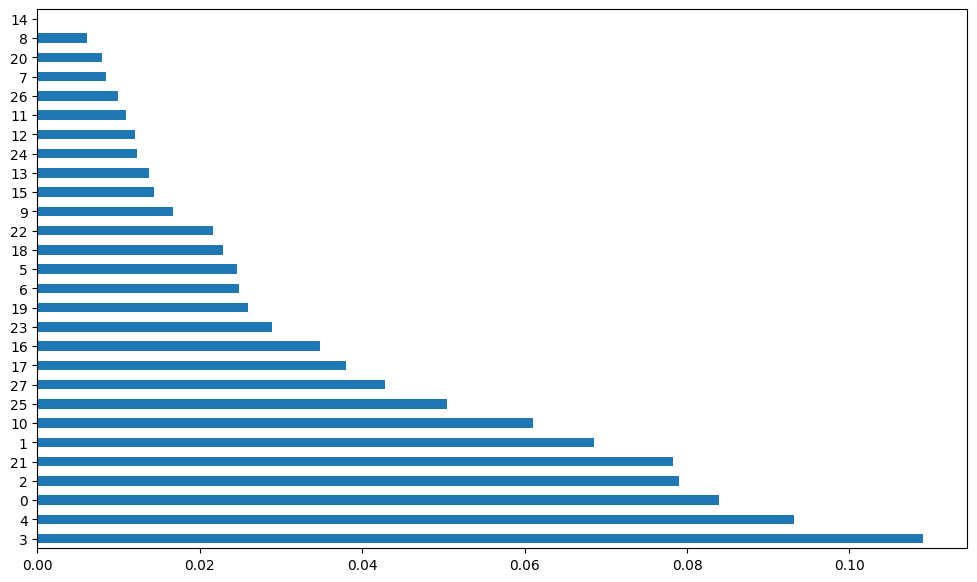

In [133]:
feature_imp(X, rf_clf).plot(kind='barh', figsize=(12,7), legend=False)

<Axes: >

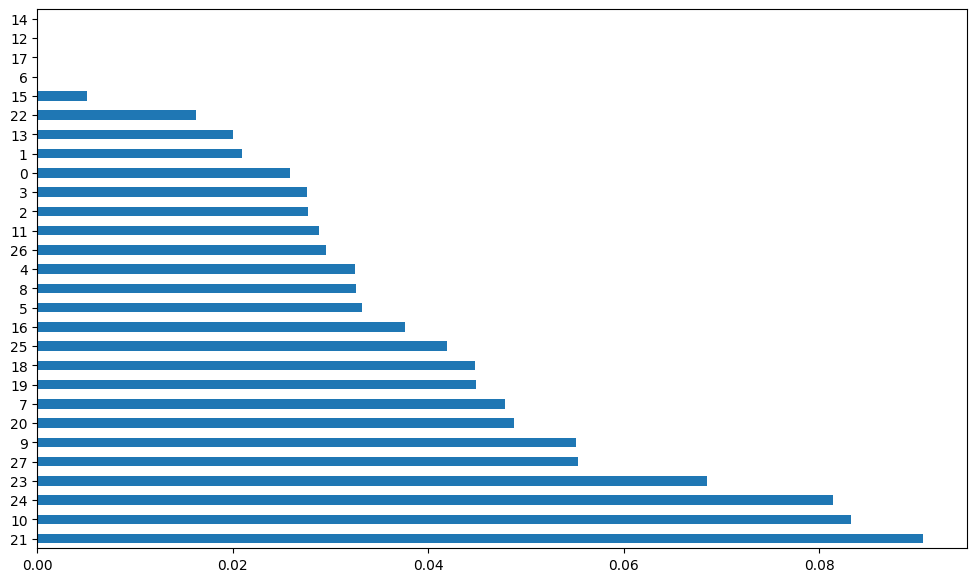

In [128]:
feature_imp(X, xgb_clf).plot(kind='barh', figsize=(12,7), legend=False)